In [1]:
import pandas as pd
import numpy as np
from joblib import dump, load

import string, os, random
import calendar
from functools import reduce

import seaborn as sns
import matplotlib.pyplot as plt

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
import plotly.express as py

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

In [2]:
"""
notebook: 1.1-simmler-data-preprocessing_accidents_severity_geo2
---------------------------------------------------------------------
explore geo information vs severity, long / lat
"""

'\nnotebook: 1.1-simmler-data-preprocessing_accidents_severity_geo2\n---------------------------------------------------------------------\nexplore geo information vs severity, long / lat\n'

In [2]:
#------------------------------------------------------------------------------------------------
# Import joblib file with 2019-2024 preprocessed data for accidents with target variable
#------------------------------------------------------------------------------------------------
df_acc_severity = load(r'..\..\data\processed\2_preprocessing\1.1-simmler-data-preprocessing_accidents_severity_reordered.joblib')

display(df_acc_severity.head(3))


,acc_num,acc_date,acc_year,acc_month,acc_hour,acc_department,acc_municipality,acc_metro,acc_long,acc_lat,acc_ambient_lightning,acc_atmosphere,acc_urbanization_level,acc_intersection,acc_collision_type,ind_num_veh,ind_severity
0,201900000001,2019-11-30,2019,11,1,93,93053,1,2.47012,48.89621,4.0,1.0,1,1.0,2.0,B01,2
2,201900000001,2019-11-30,2019,11,1,93,93053,1,2.47012,48.89621,4.0,1.0,1,1.0,2.0,A01,1
3,201900000002,2019-11-30,2019,11,2,93,93066,1,2.36880,48.93070,3.0,1.0,1,1.0,6.0,A01,2


In [3]:
# -------------------------------------------------------------------------------------------------
# copy file
# -------------------------------------------------------------------------------------------------

df_acc_target = df_acc_severity.copy()


In [4]:
# -------------------------------------------------------------------------------------------------
# define geo dataframe containing 'acc_lat', 'acc_long'
# filter for mainland france
# -------------------------------------------------------------------------------------------------

df_acc_target = df_acc_target[df_acc_target['acc_metro']==1] #data = char.loc[char['acc_metro'] == 1]

X_geo = df_acc_target[['acc_lat', 'acc_long']]
y_target = df_acc_target['ind_severity']


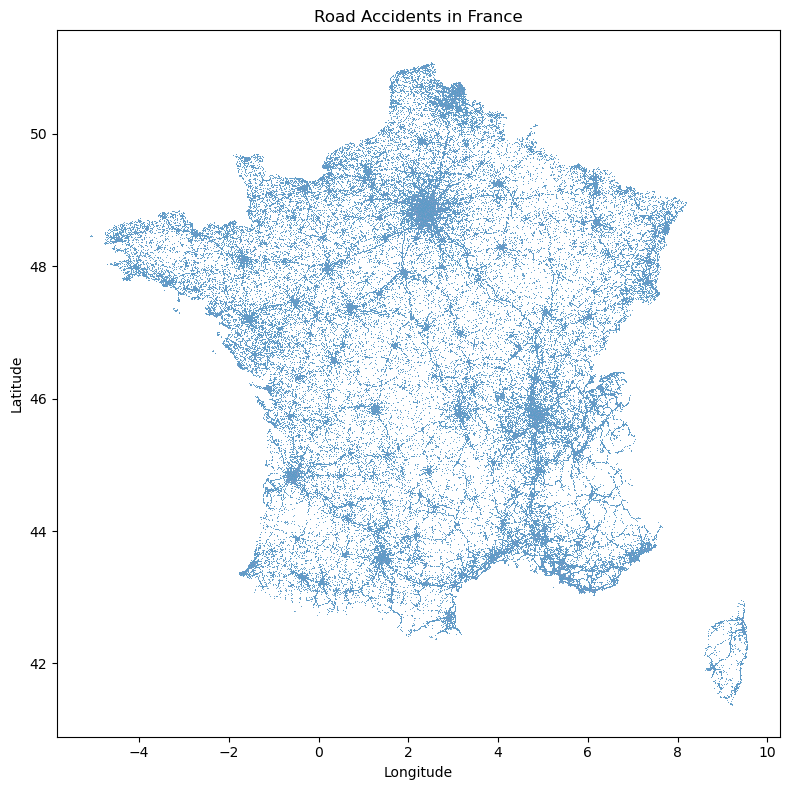

In [5]:
# -------------------------------------------------------------------------------------------------
# long/lat of accidents in Mainland France
# -------------------------------------------------------------------------------------------------

def show_metro_accidents_map(char):
    
    data = char
    if 'acc_metro' in char.columns:
        data = char.loc[char['acc_metro'] == 1]
    
    plt.figure(figsize=(8, 8))
    sns.scatterplot(data=data, x='acc_long', y='acc_lat', s=0.5) #0.8 s=0.1 s=0.5
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f"Road Accidents in France") 
    plt.tight_layout()
    plt.show()

show_metro_accidents_map(X_geo)


In [6]:
#------------------------------------------------------------------------------------------------
# define ClusterSimilarity as a wrapper for KMeans
#------------------------------------------------------------------------------------------------

class ClusterSimilarity(BaseEstimator, TransformerMixin):

    # Default number of KMeans clusters is 10, default RBF Kernel gamma is 1
    def __init__(self, n_clusters = 10, gamma = 1.0, random_state = None):
        
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y = None, sample_weight = None):
        
        self.kmeans_ = KMeans(self.n_clusters, random_state = self.random_state, n_init = "auto")
        self.kmeans_.fit(X, sample_weight = sample_weight)
        return self
        
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma = self.gamma)
        
    def get_feature_names_out(self, names = None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


In [7]:
#------------------------------------------------------------------------------------------------
# Initiate a cluster similarity object
#------------------------------------------------------------------------------------------------

cluster_simil = ClusterSimilarity(
    n_clusters = 10, #8
    gamma = 1,
    random_state = 42
)


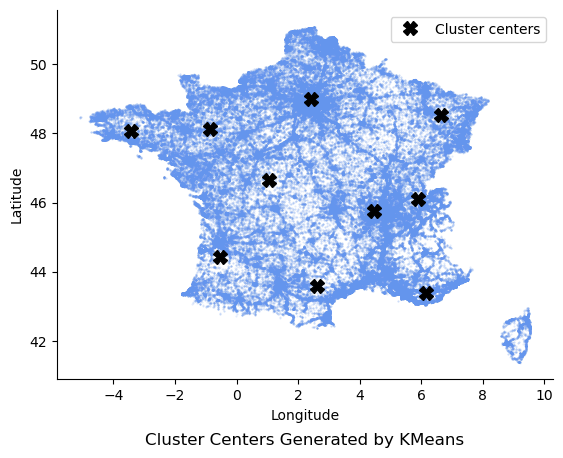

In [8]:
#------------------------------------------------------------------------------------------------
# Show KMeans clusters vs long/lat distribution
#------------------------------------------------------------------------------------------------

# Fit the cluster similarity object to the latitude and longitude columns
similarities = cluster_simil.fit_transform(X_geo) #kmeans.fit(X_geo) #q

####

# Plot: Initiate figure object
plt.figure()

# Plot the cluster centers by accessing the kmeans cluster center attribute
plt.plot(
    
    cluster_simil.kmeans_.cluster_centers_[:,1], # Longitude of cluster centre
    cluster_simil.kmeans_.cluster_centers_[:,0], # Latitude of cluster centre
    
    linestyle  = "",
    color      = "black",
    marker     = "X",
    markersize = 10,
    label      = "Cluster centers"
)

# Plot the latitude and longitude of accidents

#sns.scatterplot(data=data, x='acc_long', y='acc_lat', s=0.5) #0.8 s=0.1 s=0.5

df_acc_target.plot(
    kind  = "scatter",
    x     = "acc_long",
    y     = "acc_lat",
    c     = "cornflowerblue", #cornflowerblue #skyblue #lightskyblue #lightsteelblue #deepskyblue #dodgerblue
    s     = 0.2,
    alpha = 0.2,
    ax    = plt.gca()
)

plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
sns.despine()
plt.title("Cluster Centers Generated by KMeans", y = -0.2)
plt.show()


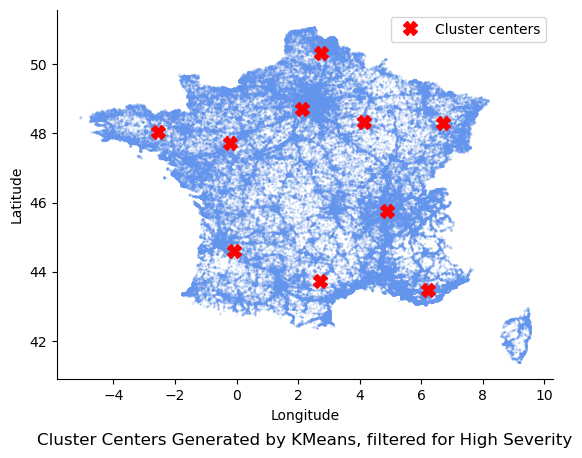

In [9]:
#------------------------------------------------------------------------------------------------
# Show KMeans clusters vs long/lat distribution for high severity classes 3 & 4
#
# Cluster Centers show a slightly different distribution
#------------------------------------------------------------------------------------------------

# Filter for high severity
df_acc_3_4 = df_acc_target[df_acc_target['ind_severity'] > 2]

X_geo_3_4 = df_acc_3_4[['acc_lat', 'acc_long']]
y_target_3_4 = df_acc_3_4['ind_severity']

####

# Fit the cluster similarity object to the latitude and longitude columns
similarities = cluster_simil.fit_transform(X_geo_3_4)

####

# Plot: Initiate figure object
plt.figure()

# Plot the cluster centers by accessing the kmeans cluster center attribute
plt.plot(
    
    cluster_simil.kmeans_.cluster_centers_[:,1], # Longitude of cluster centre
    cluster_simil.kmeans_.cluster_centers_[:,0], # Latitude of cluster centre
    
    linestyle  = "",
    color      = "red",
    marker     = "X",
    markersize = 10,
    label      = "Cluster centers"
)

# Plot the latitude and longitude of accidents

df_acc_target.plot(
    kind  = "scatter",
    x     = "acc_long",
    y     = "acc_lat",
    c     = "cornflowerblue", #cornflowerblue #skyblue #lightskyblue #lightsteelblue #deepskyblue #dodgerblue
    s     = 0.2,
    alpha = 0.2,
    ax    = plt.gca()
)

plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
sns.despine()
plt.title("Cluster Centers Generated by KMeans, filtered for High Severity", y = -0.2)
plt.show()


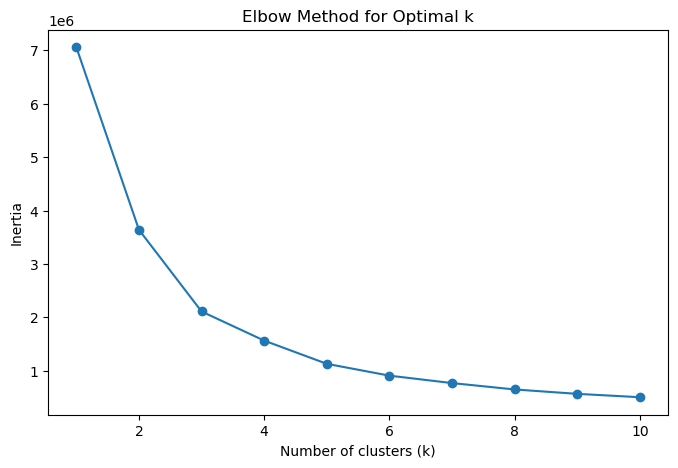

In [10]:
#------------------------------------------------------------------------------------------------
# long, lat clustering: KMeans elbow curve
#------------------------------------------------------------------------------------------------

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) #n_init = "auto"
    kmeans.fit(X_geo)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


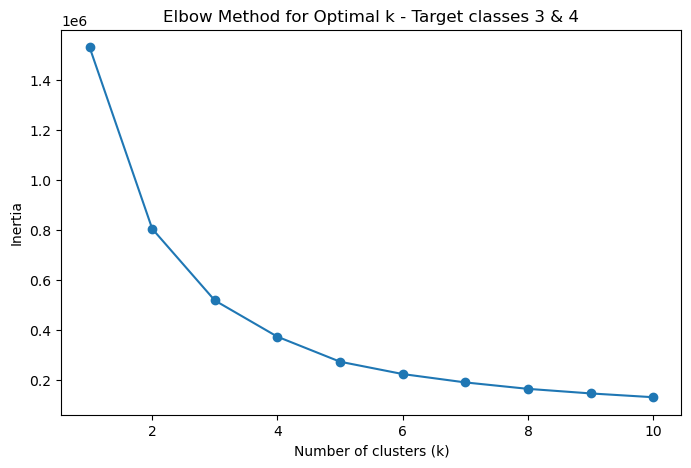

In [11]:
#------------------------------------------------------------------------------------------------
# long, lat clustering, filter for severity 3, 4
#
# for severity 3, 4 the elbow curve shows a similar distribution
#------------------------------------------------------------------------------------------------

df_acc_3_4 = df_acc_target[df_acc_target['ind_severity'] > 2]

X_geo_3_4 = df_acc_3_4[['acc_lat', 'acc_long']]
y_target_3_4 = df_acc_3_4['ind_severity']

inertia_3_4 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_geo_3_4)
    inertia_3_4.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia_3_4, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k - Target classes 3 & 4')
plt.show()


In [12]:
#------------------------------------------------------------------------------------------------
# 2: long, lat clustering: KMeans elbow curve - use cluster_simil.fit_transform
#------------------------------------------------------------------------------------------------

# Initiate empty lists to store values
k_val = []       # Number of cluster centers
inertia_val = [] # Inertia for each number of cluster centers

# Iterate through 12 values of cluster centers #15
for k in range(1, 13): #16

    # Create ClusterSimilarity object with defined number of clusters
    cluster_simil = ClusterSimilarity(
        n_clusters = k,
        gamma = 1,
        random_state = 42
    )
    
    # Fit the Cluster Similarity object
    cluster_simil.fit_transform(X_geo) #fit #q
    
    # Append attributes
    k_val.append(k)
    inertia_val.append(cluster_simil.kmeans_.inertia_)


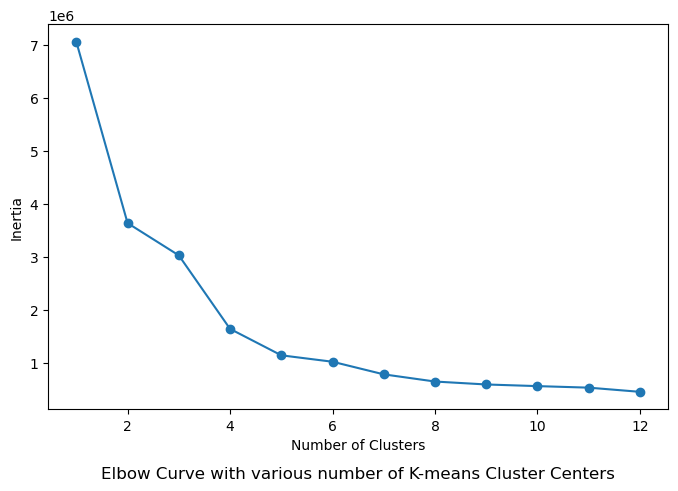

In [13]:
#------------------------------------------------------------------------------------------------
# 2: Visualize inertia values using scree plot - Elbow Curve - use cluster_simil
#------------------------------------------------------------------------------------------------

#plt.figure() 
plt.figure(figsize=(8, 5))

plt.plot(k_val, inertia_val, marker="o")

#sns.despine()
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve with various number of K-means Cluster Centers', y = -0.2)
plt.show()


In [14]:
#------------------------------------------------------------------------------------------------
# define ColumnTransformer
#------------------------------------------------------------------------------------------------

# ClusterSimilarity object
cluster_simil = ClusterSimilarity(
    n_clusters=10, 
    gamma=1, 
    random_state=42
)

# num/cat pipelines
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)
cat_pipeline = make_pipeline(
    OneHotEncoder(handle_unknown='ignore')
)

# column transformer with cluster_simil
preprocessing = ColumnTransformer(
    [
        ('acc_loc', cluster_simil, ['acc_lat', 'acc_long'])
    ],
    remainder = 'passthrough' #cat_pipeline #num_pipeline    
)


In [15]:
#------------------------------------------------------------------------------------------------
# test ColumnTransformer
#------------------------------------------------------------------------------------------------

# Test the column transformer pipeline
geo_prepared = preprocessing.fit_transform(X_geo)

# Examine data before column transformer
print(f"Before preprocessing pipeline")
display(X_geo.head())

# Extract column names from preprocessing pipeline
geo_prepared_df = pd.DataFrame(
    geo_prepared,
    columns = preprocessing.get_feature_names_out(),
    index = X_geo.index
)

# Examine data after column transformer
print(f"After preprocessing pipeline")
display(geo_prepared_df.head())


Before preprocessing pipeline


,acc_lat,acc_long
0,48.896210,2.470120
2,48.896210,2.470120
3,48.930700,2.368800
4,48.935872,2.319174
5,48.935872,2.319174


After preprocessing pipeline


,acc_loc__Cluster 0 similarity,acc_loc__Cluster 1 similarity,acc_loc__Cluster 2 similarity,acc_loc__Cluster 3 similarity,acc_loc__Cluster 4 similarity,acc_loc__Cluster 5 similarity,acc_loc__Cluster 6 similarity,acc_loc__Cluster 7 similarity,acc_loc__Cluster 8 similarity,acc_loc__Cluster 9 similarity
0,9.710080e-20,0.000848,2.253243e-08,2.035318e-13,0.989445,0.000009,3.501092e-09,6.096089e-13,3.958736e-16,8.839704e-07
2,9.710080e-20,0.000848,2.253243e-08,2.035318e-13,0.989445,0.000009,3.501092e-09,6.096089e-13,3.958736e-16,8.839704e-07
3,3.119737e-20,0.000956,9.311725e-09,2.724490e-13,0.993202,0.000017,1.429518e-09,4.047831e-13,1.222045e-15,4.679430e-07
4,2.020508e-20,0.001060,6.047811e-09,3.465675e-13,0.985657,0.000023,9.772060e-10,3.723274e-13,2.148051e-15,3.662211e-07
5,2.020508e-20,0.001060,6.047811e-09,3.465675e-13,0.985657,0.000023,9.772060e-10,3.723274e-13,2.148051e-15,3.662211e-07


In [16]:
#------------------------------------------------------------------------------------------------
# rename transformed columns
#------------------------------------------------------------------------------------------------

for i in range(0, 10):
    col_name = f"acc_loc__Cluster {i} similarity"
    geo_prepared_df.rename(columns={col_name: f"acc_loc_{i}"}, inplace=True)

geo_prepared_df.head()


,acc_loc_0,acc_loc_1,acc_loc_2,acc_loc_3,acc_loc_4,acc_loc_5,acc_loc_6,acc_loc_7,acc_loc_8,acc_loc_9
0,9.710080e-20,0.000848,2.253243e-08,2.035318e-13,0.989445,0.000009,3.501092e-09,6.096089e-13,3.958736e-16,8.839704e-07
2,9.710080e-20,0.000848,2.253243e-08,2.035318e-13,0.989445,0.000009,3.501092e-09,6.096089e-13,3.958736e-16,8.839704e-07
3,3.119737e-20,0.000956,9.311725e-09,2.724490e-13,0.993202,0.000017,1.429518e-09,4.047831e-13,1.222045e-15,4.679430e-07
4,2.020508e-20,0.001060,6.047811e-09,3.465675e-13,0.985657,0.000023,9.772060e-10,3.723274e-13,2.148051e-15,3.662211e-07
5,2.020508e-20,0.001060,6.047811e-09,3.465675e-13,0.985657,0.000023,9.772060e-10,3.723274e-13,2.148051e-15,3.662211e-07
